In [993]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,roc_curve, auc,accuracy_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [994]:
df_tweets = pd.read_csv("../Data/cleaned_tweets.csv")
df_tweets = df_tweets[["tweet","sentiment"]]

# define a function to add label
def row_label(row):
    return 1 if row["sentiment"]=="Positive" else 0

# def remove_brakets(row):
#     return row["tweet"].replace(']','').replace
def remove_brakets(row):
    string= re.sub('\[|\]|\'|\.|"|,', '', row["tweet"])
    #string = string.replace(",","")
    return string

df_tweets["label"] = df_tweets.apply(row_label, axis=1)
# df_tweets["tweet"] = df_tweets.apply(remove_brakets, axis=1)
df_tweets.drop("sentiment",axis=1, inplace=True)

df_tweets.drop_duplicates()
#reduce the data
df_tweets_inp = df_tweets.sample(frac=0.9, random_state=42)
df_test = df_tweets.drop(df_tweets_inp.index)
#df_test = df_test.sample(frac=0.1, random_state=42)

#seperate labelled and unlabelled data
df_labeled_data = df_tweets_inp.sample(frac=0.25, random_state=42)
df_unlabeled_data = df_tweets_inp.drop(df_labeled_data.index)
#df_unlabeled_data.drop("label",axis=1, inplace=True)
#print(df_test[df_test["label"]==1].count,df_test[df_test["label"]==0].count)
#print(df_labeled_data[df_labeled_data["label"]==1].count,df_labeled_data[df_labeled_data["label"]==0].count)



df_tweets.head(10)

,tweet,label
0,"['im', 'get', 'borderland', 'murder']",1
1,"['come', 'border', 'kill']",1
2,"['im', 'get', 'borderland', 'kill']",1
3,"['im', 'come', 'borderland', 'murder']",1
4,"['im', 'get', 'borderland', '2', 'murder']",1
5,"['im', 'get', 'borderland', 'murder']",1
6,"['spent', 'hour', 'make', 'someth', 'fun', '. ...",1
7,"['spent', 'coupl', 'hour', 'someth', 'fun', 'k...",1
8,"['spent', 'hour', 'someth', 'fun', 'know', ""i'...",1
9,"['spent', 'hour', 'make', 'someth', 'fun', '. ...",1


In [995]:
# convert text data into numerical feature vectors using TF-IDF vectorization
vectorizer = TfidfVectorizer()
labeled_features = vectorizer.fit_transform(df_labeled_data['tweet'])
test_features = vectorizer.transform(df_test['tweet'])

In [996]:
# train a logistic regression model on the labeled data
# model = LogisticRegression()
# model = MultinomialNB()

# model = Sequential()
# vocab_size = 25000
# max_length = 21
# model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
# model.add(LSTM(units=64))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model = LogisticRegression(max_iter=1000)
model.fit(labeled_features, df_labeled_data['label'])

# evaluate the performance of the model on the test data
accuracy = model.score(test_features, df_test['label'])
print("Accuracy Supervised:", accuracy)


Accuracy Supervised: 0.8437572657521507


In [997]:
def splitData(dataframe,noofdivision):
    # list = []
    # totaldfsize = dataframe.shape[0]
    # for i in range(1,noofdivision+1):
    dataframe = dataframe.sample(frac=1)
    lst_dfs = np.array_split(dataframe,noofdivision)
    return lst_dfs
# totaldfsize = df_unlabeled_data.shape[0]
# print(totaldfsize)
# lst_dfs = splitData(df_unlabeled_data,5)
# len(lst_dfs)

def selftrain(model,df_lab_data,lst_dfs,ini_acc):
    threshold_acc = ini_acc
    i = 0
    for df in lst_dfs:
       i +=1
       unlabeled_features = vectorizer.transform(df['tweet'])
       probabilities = model.predict_proba(unlabeled_features)
       confidence = np.max(probabilities, axis=1)
       threshold = np.percentile(confidence, 0.1)
       indices = np.where(confidence >= threshold)[0]
       df_prev_lab = df_lab_data
       df_lab_data = df_lab_data.append(df.iloc[indices])
       labeled_features = vectorizer.transform(df_lab_data['tweet']) 
       model.fit(labeled_features, df_lab_data['label'])
       acurcy = model.score(test_features, df_test['label'])
       print("Accuracy",i,acurcy)
       if(acurcy < threshold_acc):
           df_lab_data = df_prev_lab
    return model

lst_dfs = splitData(df_unlabeled_data,5)

model = selftrain(model,df_labeled_data,lst_dfs,accuracy)




Accuracy 1 0.8604975587072774
Accuracy 2 0.8681701929783772
Accuracy 3 0.8763078353871193
Accuracy 4 0.8832829574517554
Accuracy 5 0.8865380144152523


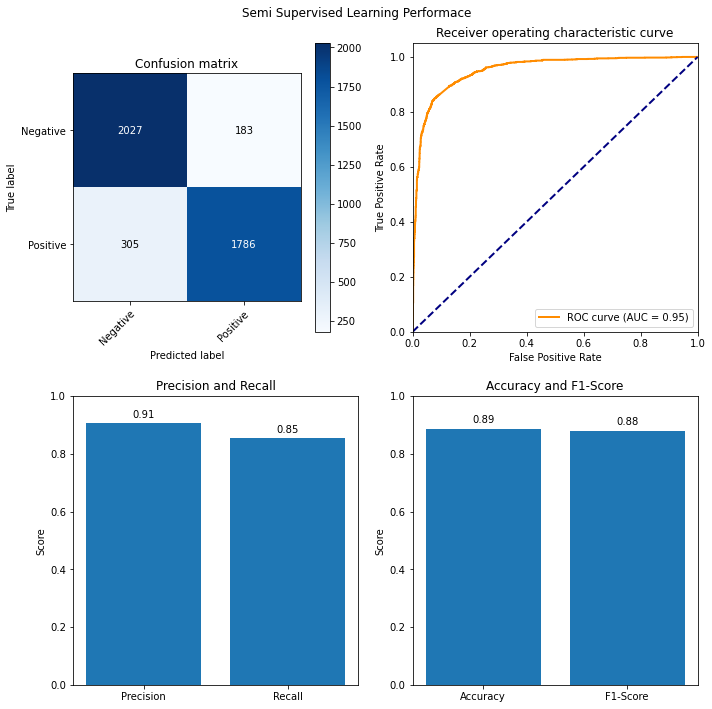

In [998]:
#plots
# assume y_true is the true labels and y_pred is the predicted labels
y_true = np.array(df_test['label'])
unlabeled_features = vectorizer.transform(df_test['tweet'])
predicted_sentiments = model.predict(unlabeled_features)
y_pred = np.array(predicted_sentiments)
y_score = model.predict_proba(unlabeled_features)[:, 1]
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)



# create figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot confusion matrix
ax = axs[0,0]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Negative", "Positive"],
       yticklabels=["Negative", "Positive"],
       title="Confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# plot precision,accuracy, F1 and recall
# calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

ax = axs[1,0]
ax.bar(["Precision", "Recall"], [precision, recall])
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Precision and Recall")
for i, v in enumerate([precision, recall ]):
    ax.text(i, v + 0.02, str(round(v, 2)), ha='center')

#accuracy, F1
ax = axs[1,1]
ax.bar(["Accuracy" , "F1-Score"], [ acc, f1])
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Accuracy and F1-Score")
for i, v in enumerate([acc, f1]):
    ax.text(i, v + 0.02, str(round(v, 2)), ha='center')


#ROC Curve


# calculate false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
ax =  axs[0,1]
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic curve')
ax.legend(loc="lower right")

# remove axis labels for the bottom right subplot
# axs[1, 1].axis('off')

# add a figure title
fig.suptitle('Semi Supervised Learning Performace')

# adjust subplot spacing and layout
fig.tight_layout()

# show the plot
plt.show()



In [999]:
# predict the sentiment of the unlabeled data
# unlabeled_features = vectorizer.transform(df_unlabeled_data['tweet'])
# predicted_sentiments = model.predict(unlabeled_features)

In [1000]:
# select the most confident predictions and add them to the labeled data
# probabilities = model.predict_proba(unlabeled_features)
# confidence = np.max(probabilities, axis=1)
# threshold = np.percentile(confidence, 0.1)
# indices = np.where(confidence >= threshold)[0]
# df_labeled_data = df_labeled_data.append(df_unlabeled_data.iloc[indices])
# labeled_features = vectorizer.transform(df_labeled_data['tweet'])

In [1001]:
# # retrain the model on the updated labeled data
# model.fit(labeled_features, df_labeled_data['label'])

# # evaluate the performance of the model on the test data
# accuracy = model.score(test_features, df_test['label'])
# print("Accuracy: SemiSupervised", accuracy)